In [ ]:
"""
pldl_simulation.py:  Monte-Carlo demo of three crowd-label aggregation strategies

  1. Majority vote (unweighted)
  2. Importance-weighted vote (post-stratification)
  3. **Cluster-then-weight (PLDL-weighted)**

Clusters are estimated purely from each item's label-distribution vector using
k-means; inside every cluster we re-weight each annotator-group's votes by
w_g = γ_g / α_g to match the target population mix.  This is a lightweight
proxy for the Dirichlet-multinomial approach in Liu et al. (2019).

Usage
-----
$ python pldl_simulation.py

Outputs “results.csv” and a PNG figure of Bias & RMSE across parameter grids.
"""

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.special import softmax
import matplotlib.pyplot as plt

np.random.seed(42)

# ------------------------ 1. GLOBAL PARAMS -----------------------------
N_ITEMS   = 1000      # items per simulation
N_SIMS    = 100       # Monte-Carlo reps
N_LABELS  = 5         # labels per item
G         = 2         # annotator groups (1 & 2)
K         = 2         # label categories (binary)
N_CLUST   = 6         # k-means clusters for PLDL

# grid of scenarios – match Higton paper
ALPHAS    = np.round(np.arange(0.50, 0.96, 0.10), 2)   # annotator share of group 1
GDIFFS    = np.array([0.72, 1.31])               # group-difference parameter (δ)
GAMMA     = 0.50                                       # population share of group 1

# ------------------------ 2. HELPERS -----------------------------------

def logistic(x):
    return 1 / (1 + np.exp(-x))


def generate_dataset(n_items, alpha1, gamma1, delta):
    """Synthetic items, annotator labels, true population prob per item"""
    x  = np.random.randn(n_items)
    max_diff = logistic(delta) - logistic(-delta)
    p1 = logistic(x / max_diff + delta)       # prob(Y=1 | group 1)
    p2 = logistic(x / max_diff - delta)       # prob(Y=1 | group 2)

    labels          = np.zeros((n_items, N_LABELS), dtype=int)
    annotator_group = np.random.binomial(1, alpha1, size=N_LABELS)  # fixed across items

    for i in range(n_items):
        for j in range(N_LABELS):
            prob = p1[i] if annotator_group[j] else p2[i]
            labels[i, j] = np.random.binomial(1, prob)

    true_prob = gamma1 * p1 + (1 - gamma1) * p2
    return x, labels, annotator_group, true_prob


def evaluate(pred, truth):
    bias = np.mean(pred - truth)
    rmse = np.sqrt(np.mean((pred - truth) ** 2))
    # simple ECE 10 bins
    bins   = np.linspace(0, 1, 11)
    digit  = np.digitize(pred, bins) - 1
    ece    = 0.0
    for b in range(10):
        mask = digit == b
        if mask.any():
            ece += np.abs(np.mean(pred[mask]) - np.mean(truth[mask])) * np.mean(mask)
    return bias, rmse, ece


# ------------------------ 3. PLDL WEIGHTED -----------------------------

def pldl_weighted_preds(labels, annotator_group, gamma1, alpha1):
    """Cluster on label fingerprints then importance-weight inside clusters"""
    n_items, n_labels = labels.shape

    # Build label proportion matrix Q (N × K)
    Q = np.stack([(1 - labels).mean(axis=1), labels.mean(axis=1)], axis=1)

    # Cluster items by Q
    kmeans = KMeans(n_clusters=N_CLUST, n_init=20, random_state=1)
    clusters = kmeans.fit_predict(Q)

    # Pre-compute weights
    w = np.array([gamma1 / alpha1, (1 - gamma1) / (1 - alpha1)])

    # For each cluster compute weighted proportion of 1's
    p_cluster = np.zeros(N_CLUST)
    for c in range(N_CLUST):
        idx = clusters == c
        if not idx.any():
            continue
        # counts by annotator group
        n_cg1 = ((labels[idx][:, annotator_group == 1]).sum())
        n_cg0 = ((labels[idx][:, annotator_group == 0]).sum())
        d_cg1 = ((annotator_group == 1).sum() * idx.sum())
        d_cg0 = ((annotator_group == 0).sum() * idx.sum())
        # weighted
        num = w[0] * n_cg1 + w[1] * n_cg0
        den = w[0] * d_cg1 + w[1] * d_cg0
        p_cluster[c] = num / den if den > 0 else 0.5

    return p_cluster[clusters]

# ------------------------ 4. SIMULATION LOOP --------------------------

records = []

for delta in GDIFFS:
    for alpha1 in ALPHAS:
        for s in range(N_SIMS):
            x, lab, a_group, truth = generate_dataset(N_ITEMS, alpha1, GAMMA, delta)

            # 1. majority vote
            mv_pred = lab.mean(axis=1)
            mv_metrics = evaluate(mv_pred, truth)
            records.append((*mv_metrics, alpha1, delta, 'Majority'))

            # 2. weighted vote
            w1, w2 = GAMMA / alpha1, (1 - GAMMA) / (1 - alpha1)
            weights = np.where(a_group == 1, w1, w2)
            w_pred = (lab * weights).sum(axis=1) / weights.sum()
            w_metrics = evaluate(w_pred, truth)
            records.append((*w_metrics, alpha1, delta, 'Weighted'))

            # 3. PLDL weighted
            pldl_pred = pldl_weighted_preds(lab, a_group, GAMMA, alpha1)
            pldl_metrics = evaluate(pldl_pred, truth)
            records.append((*pldl_metrics, alpha1, delta, 'PLDL-Weighted'))

# to DataFrame
cols = ['bias', 'rmse', 'ece', 'alpha', 'delta', 'method']
results = pd.DataFrame.from_records(records, columns=cols)
results.to_csv('pldl_sim_results.csv', index=False)


/Users/joe/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/joe/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/joe/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/joe/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/joe/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/joe/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_w

Simulation finished. CSV and PNGs saved.


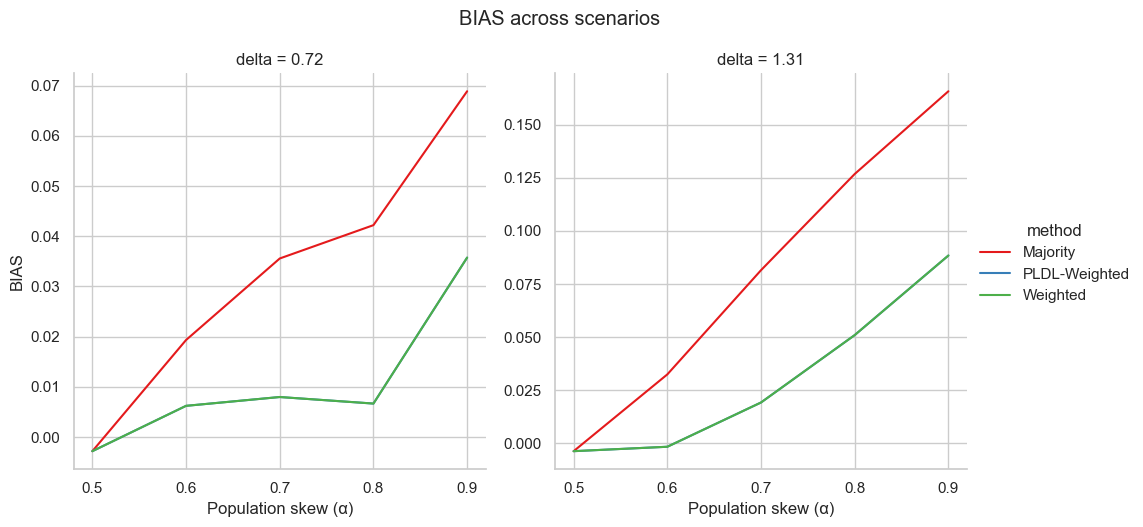

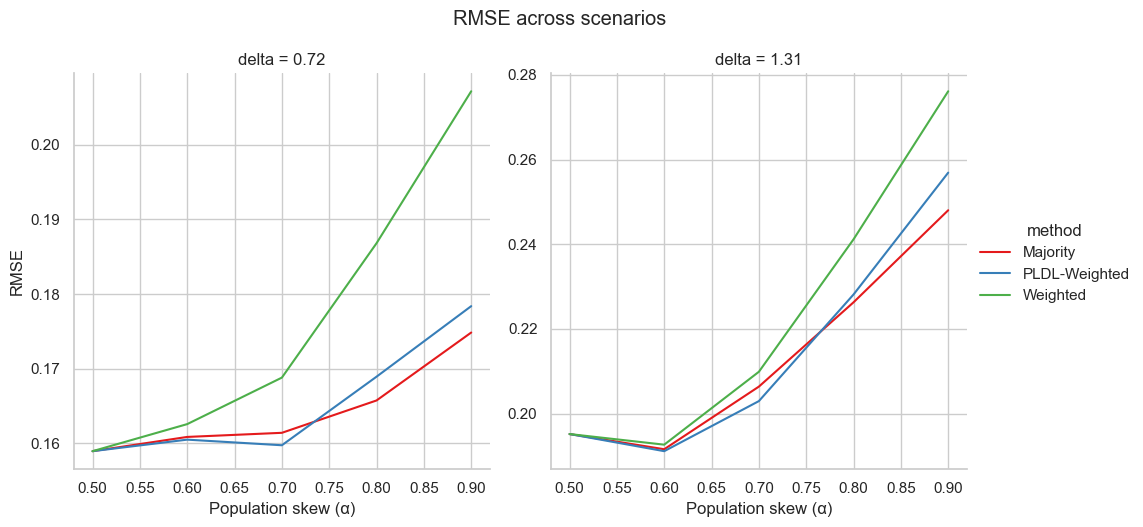

In [3]:

# ------------------------ 5. PLOTS ------------------------------------
import seaborn as sns
sns.set_theme(style='whitegrid')

def plot_metric(metric):
    df = results.groupby(['alpha', 'delta', 'method'])[metric].mean().reset_index()
    g = sns.relplot(data=df, x='alpha', y=metric, hue='method', col='delta', kind='line',
                    palette='Set1', facet_kws={'sharey': False})
    g.set_axis_labels('Population skew (α)', metric.upper())
    g.fig.suptitle(f'{metric.upper()} across scenarios', y=1.05)
    #plt.savefig(f'{metric}.png', dpi=300, bbox_inches='tight')

for m in ['bias', 'rmse']:
    plot_metric(m)

print('Simulation finished. CSV and PNGs saved.')